hfd data wrangling

In [1]:
!pip install h5py

john imports

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np
import math
import h5py
import random
from scipy.signal import find_peaks, peak_widths
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix,  ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

john google drive (data)

In [3]:
# mount the google drive - this is necessary to access supporting resources
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


john standardize (so those samples where it goes like _/- get flatted to ---)

In [4]:
def standardize_wave(signal):
    signal = np.asarray(signal)

    # If signal is too short to compute differences, return empty
    if len(signal) < 2:
        return np.array([])

    # Compute the discrete derivative
    diff_signal = np.diff(signal)

    # Z-score the derivative: (x - mean) / std
    mean_diff = np.mean(diff_signal)
    std_diff = np.std(diff_signal)

    # To avoid division by zero if the std is 0, handle gracefully:
    if std_diff == 0:
        # This would mean the signal differences are all the same (or all zero)
        # so we can just return a zero array of the same shape
        return np.zeros_like(diff_signal)

    standardized_diff = (diff_signal - mean_diff) / std_diff

    return standardized_diff

reads in waveforms to arrays in dataframe, standardizes them

In [5]:
labels_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CPSC-4300/data/code15_chagas_labels.csv")

records = []

# Define the lead names in the order stored in the HDF5 file.
lead_names = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF',
              'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Open the HDF5 file.
with h5py.File("/content/drive/MyDrive/Colab Notebooks/CPSC-4300/data/exams_part0.hdf5", "r") as f:
    # Load the exam ids (assumed small enough to load into memory)
    exam_ids_hdf5 = f['exam_id'][:]  # shape: (N,)
    # Build a mapping from exam_id (converted to string) to its index.
    exam_id_to_index = {str(eid): idx for idx, eid in enumerate(exam_ids_hdf5)}

    # Access the tracings dataset without converting the whole thing to a NumPy array.
    tracings = f['tracings']  # shape: (N, 4096, 12)

    # Process each exam_id from the CSV.
    for _, row in labels_df.iterrows():
        exam_id = str(row['exam_id'])
        chagas_val = row['chagas']

        # Ensure the exam_id exists in the HDF5 file.
        if exam_id in exam_id_to_index:
            index = exam_id_to_index[exam_id]
            # Read only the required chunk for this exam_id.
            ecg_data = tracings[index, :, :]  # shape: (4096, 12)

            # Create a record for the DataFrame.
            record = {"exam_id": exam_id, "chagas": chagas_val}
            # For each lead, extract the corresponding signal and trim leading/trailing zeros.
            for j, lead in enumerate(lead_names):
                signal = ecg_data[:, j]
                # Find indices of non-zero elements.
                nonzero_indices = np.nonzero(signal)[0]
                if nonzero_indices.size > 0:
                    start = nonzero_indices[0]
                    end = nonzero_indices[-1] + 1  # +1 to include the last non-zero element.
                    trimmed_signal = signal[start:end]
                else:
                    # If the signal is all zeros, leave it unchanged.
                    trimmed_signal = signal
                record[lead] = trimmed_signal

            records.append(record)

# Construct a pandas DataFrame from the collected records.
df = pd.DataFrame(records)

# --- Standardize each ECG signal array for each lead ---
for lead in lead_names:
  df[lead] = df[lead].apply(lambda signal: standardize_wave(signal))

# Example: print the first row to see the standardized arrays.
# print(df.head())

average and standard deviations of both qrs distance approximation (i tried using neurokit2's ecg delineate to get it but it wasn't working as was really slow) and peak-to-peak distance

In [6]:
def average_qrs_distance(ecg, relative_height=0.3):
    ecg = np.asarray(ecg)

    # Find peaks. You can customize the parameters (like prominence or height) if needed.
    peaks, _ = find_peaks(ecg, height=2)

    if len(peaks) == 0:
        return np.nan

    # Compute widths of the detected peaks at the specified relative height.
    widths_results = peak_widths(ecg, peaks, rel_height=relative_height)
    widths = widths_results[0]  # the first element contains the widths

    return np.mean(widths)

def std_qrs_distance(ecg, relative_height=0.3):
    ecg = np.asarray(ecg)

    # Find peaks. You can customize the parameters (like prominence or height) if needed.
    peaks, _ = find_peaks(ecg, height=2)

    if len(peaks) == 0:
        return np.nan

    # Compute widths of the detected peaks at the specified relative height.
    widths_results = peak_widths(ecg, peaks, rel_height=relative_height)
    widths = widths_results[0]  # the first element contains the widths

    return np.std(widths)

def avg_peak_to_peak(signal, height=2, distance=40):
    # Detect peaks using the specified parameters.
    peak_indices, _ = find_peaks(signal, height=height, distance=distance)

    # If fewer than two peaks are found, return NaN.
    if len(peak_indices) < 2:
        return np.nan

    # Calculate the distances between successive peaks.
    peak_to_peak_distances = np.diff(peak_indices)

    # Return the average of these distances.
    return np.mean(peak_to_peak_distances)

def std_peak_to_peak(signal, height=2, distance=40):
    # Detect peaks using the specified parameters.
    peak_indices, _ = find_peaks(signal, height=height, distance=distance)

    # If fewer than two peaks are found, return NaN.
    if len(peak_indices) < 2:
        return np.nan

    # Calculate the distances between successive peaks.
    peak_to_peak_distances = np.diff(peak_indices)

    # Return the average of these distances.
    return np.std(peak_to_peak_distances)

def avg_fft_angles(signal):
    # Assume 'signal' is your input array
    fft_result = np.fft.fft(signal)

    # Compute phases
    phases = np.angle(fft_result)

    if len(phases) < 2:
      return np.nan

    return np.mean(phases)

def std_fft_angles(signal):
    # Assume 'signal' is your input array
    fft_result = np.fft.fft(signal)

    # Compute phases
    phases = np.angle(fft_result)

    if len(phases) < 2:
      return np.nan

    return np.std(phases)

def avg_fft_magnitudes(signal):
    # Assume 'signal' is your input array
    fft_result = np.fft.fft(signal)

    # Compute magnitudes
    magnitudes = np.abs(fft_result)

    if len(magnitudes) < 2:
      return np.nan

    return np.mean(magnitudes)

def std_fft_magnitudes(signal):
    # Assume 'signal' is your input array
    fft_result = np.fft.fft(signal)

    # Compute magnitudes
    magnitudes = np.abs(fft_result)

    if len(magnitudes) < 2:
      return np.nan

    return np.std(magnitudes)

these next few are all in separate cells so you can add a new feature without rerunning everything

avg qrs

In [7]:
new_columns = {}
for lead in lead_names:
    new_columns[f"avg_qrs_{lead}"] = df[lead].apply(lambda wave: average_qrs_distance(wave))
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

std qrs

In [8]:
new_columns = {}
for lead in lead_names:
    new_columns[f"std_qrs_{lead}"] = df[lead].apply(lambda wave: std_qrs_distance(wave))
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

avg p2p

In [9]:
new_columns = {}
for lead in lead_names:
    new_columns[f"avg_p2p_{lead}"] = df[lead].apply(lambda signal: avg_peak_to_peak(signal))
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

std p2p

In [10]:
new_columns = {}
for lead in lead_names:
    new_columns[f"std_p2p_{lead}"] = df[lead].apply(lambda signal: std_peak_to_peak(signal))
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

min value

In [11]:
new_columns = {}
for lead in lead_names:
    new_columns[f'min_{lead}'] = df[lead].apply(lambda signal: np.min(signal) if len(signal) > 0 else np.nan)
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

std of signal

In [12]:
new_columns = {}
for lead in lead_names:
    new_columns[f'std_{lead}'] = df[lead].apply(lambda signal: np.std(signal) if len(signal) > 0 else np.nan)
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

max value

In [13]:
new_columns = {}
for lead in lead_names:
    df[f'max_{lead}'] = df[lead].apply(lambda signal: np.max(signal) if len(signal) > 0 else np.nan)
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

avg fft angles

In [14]:
new_columns = {}
for lead in lead_names:
    df[f"avg_fft_angles_{lead}"] = df[lead].apply(lambda signal: avg_fft_angles(signal))
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

std fft angles

In [15]:
new_columns = {}
for lead in lead_names:
    new_columns[f"std_fft_angles_{lead}"] = df[lead].apply(lambda signal: std_fft_angles(signal))
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

avg fft magnitudes

In [16]:
new_columns = {}
for lead in lead_names:
    new_columns[f"avg_fft_magnitudes_{lead}"] = df[lead].apply(lambda signal: avg_fft_magnitudes(signal))
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

std fft magnitudes

In [17]:
new_columns = {}
for lead in lead_names:
    new_columns[f"std_fft_magnitudes_{lead}"] = df[lead].apply(lambda signal: std_fft_magnitudes(signal))
new_columns_df = pd.DataFrame(new_columns)
df = pd.concat([df, new_columns_df], axis=1)

drops the waveform data, exam_id, and NaN

In [18]:
df = df.copy()
df2 = df.drop(columns=lead_names + ["exam_id"])
df2 = df2.dropna()

test train split 80/20

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop('chagas', axis=1), df2.chagas, test_size=0.2, random_state=1989)

john standard

In [20]:
# let's standardize the data
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)
# transform the training data and put it into a new dataframe
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# transform the testing data and put it into a new dataframe
# notice -- we do not fit on the test data
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

to try and help handle class imbalance

In [62]:
smote = SMOTE(random_state=1989)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

balanced random forest classifier also attempts to deal with class imbalance

grid search for optimal parameters

In [63]:
# model_rf = BalancedRandomForestClassifier(n_estimators=100, random_state=1989, criterion = 'gini', max_depth = 30, bootstrap = True)
# model_rf.fit(X_train_scaled, y_train)

model = BalancedRandomForestClassifier()

# Specify hyperparameters and their possible values
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='precision')

# Fit to the data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
model_rf = grid_search.best_estimator_

the optimal parameters in question

In [64]:
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [80]:
feature_names = [col for col in df2.columns if col != 'chagas']

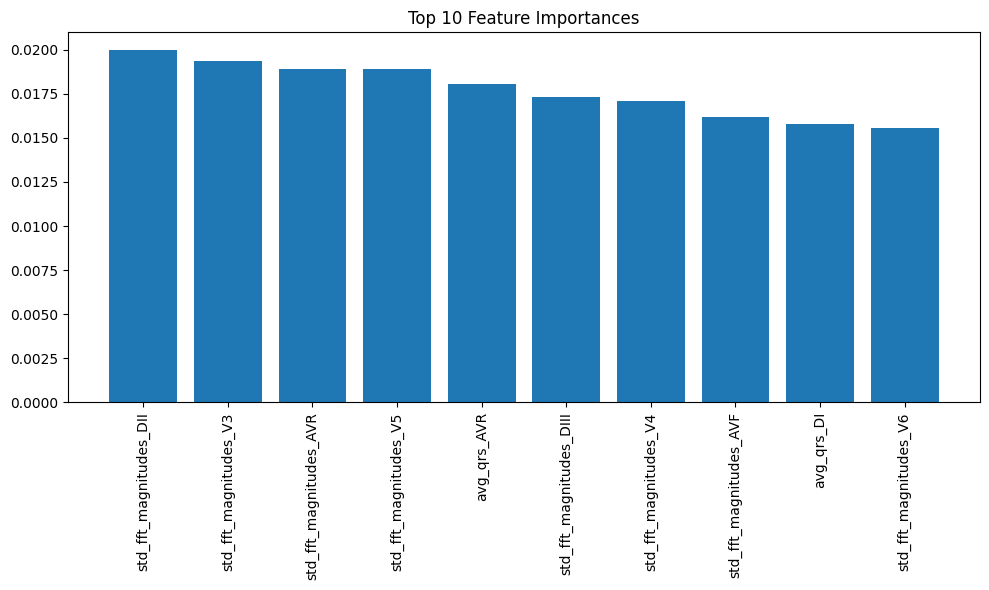

In [81]:
importances = model_rf.feature_importances_

# Sort the feature importances in descending order and select the top 10
indices = np.argsort(importances)[::-1][:10]

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

checks that jawn

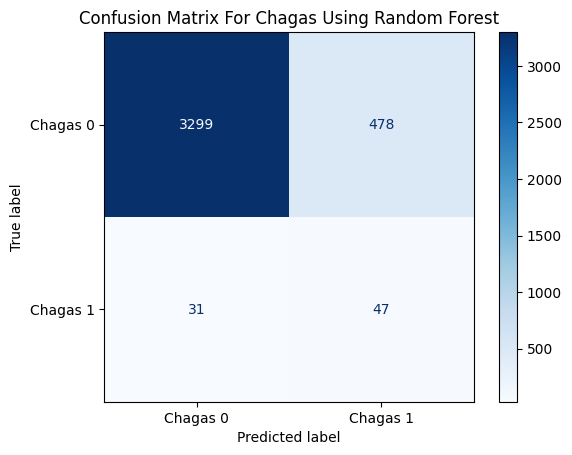

In [65]:
predictions = model_rf.predict(X_test_scaled)

y_prob = model_rf.predict_proba(X_test_scaled)[:, 1]

# Set your new threshold (e.g., 0.3 instead of the default 0.5)
threshold = 0.52
y_pred_adjusted = (y_prob >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_adjusted)
disp = ConfusionMatrixDisplay(cm, display_labels=[f'Chagas {i}' for i in range(2)])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix For Chagas Using Random Forest')
plt.show()

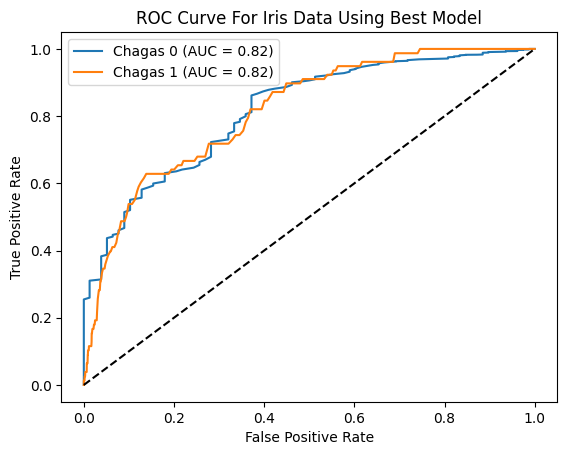

In [84]:
# let's plot the roc curve for each class
# we need to get the probabilities for each class
probs = model_rf.predict_proba(X_test_scaled)
fpr = dict()
tpr = dict()
roc_auc = {0:0, 1:0}
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, probs[:, i], pos_label=i)
    # roc_auc expects binary values, so we need to convert the target to binary
    # we're using one vs. all, so we'll convert the target to 1 for the class we're interested in and 0 for the other classes
    y_test_i = np.array(y_test == i).astype(int)
    roc_auc[i] = roc_auc_score(y_test_i, probs[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Chagas {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Iris Data Using Best Model')
plt.legend()
plt.show()

In [82]:
report = classification_report(y_test, y_pred_adjusted)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.87      0.93      3777
        True       0.09      0.60      0.16        78

    accuracy                           0.87      3855
   macro avg       0.54      0.74      0.54      3855
weighted avg       0.97      0.87      0.91      3855

